# Identify when a record begins based on data availability.

## Code!

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

%matplotlib inline

### Collect file paths.

In [2]:
obslens_tseries_dir = '/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS/'

#### Collect GISTEMP 5x5 file paths.

In [3]:
gistemp_5x5_files = glob.glob('%s/GISTEMP_5x5/20240820/xagg/ensembleChunk_5x5_????.nc' % obslens_tseries_dir)
gistemp_5x5_files.sort()

#### Collect HadCRUT5 file paths.

In [4]:
hadcrut5_files = glob.glob('%s/HadCRUT5/20240820/xagg/HadCRUT.5.0.2.0.analysis.anomalies.*.nc' % obslens_tseries_dir)
hadcrut5_files = [i for i in hadcrut5_files if "Trends" not in i]
hadcrut5_files.sort()

#### Collect DCENT unfilled file paths.

In [5]:
dcent_unfilled_files = glob.glob('%s/DCENT/20240901/xagg/DCENT_ensemble_1850_2023_member_???.nc' % obslens_tseries_dir)
dcent_unfilled_files = [i for i in dcent_unfilled_files if "Trends" not in i]
dcent_unfilled_files.sort()

## Identify a start year based on data availability

In [6]:
test_gistemp = xr.open_dataset(gistemp_5x5_files[0]).sel(time=slice(None, "2020"))
test_hadcrut = xr.open_dataset(hadcrut5_files[0]).sel(time=slice(None, "2020"))

In [7]:
test_annual = test_hadcrut["tas"].groupby("time.year").mean(dim="time", skipna=False) # skipna!!

The simplest approach excludes too much data!

In [ ]:
def startyear1(
    data_annual: xr.DataArray,
):
    """_summary_

    Args:
        data_annual (xr.DataArray): Actual data in an annual mean resolution. Remember use skipna=False!

    Returns:
        startyear_full: xarray DataArray with the start year for each region.
    """
    # Compute the last nan year and step one year forward.
    startyear = data_annual["year"].where(np.isnan(data_annual)).max(dim="year") + 1

    complete_tseries = ~np.isnan(data_annual).any(dim="year") # Identify regions without any nans
    absent_tseries = (startyear == data_annual.year[-1]) | (startyear == data_annual.year[-1] + 1) # Identify regions with all nans

    # Set the complete years to the record start year
    startyear_full = xr.where(complete_tseries, data_annual.year[0], startyear)
    # Set the years with consistent missing data to no start year
    startyear_full = xr.where(absent_tseries, np.nan, startyear_full)
    
    return startyear_full

In [8]:
# Simplest approach, startdate is after the last nan
# Add one because this was the last nan, not the first actual number
startyear = test_annual["year"].where(np.isnan(test_annual)).max(dim="year") + 1

complete_tseries = ~np.isnan(test_annual).any(dim="year") # Regions without any nans
absent_tseries = (startyear == test_annual.year[-1]) | (startyear == test_annual.year[-1] + 1) # Regions with all nans

# Set the complete years to the record start year
startyear_full = xr.where(complete_tseries, test_annual.year[0], startyear)
# Set the years with consistent missing data to no start year
startyear_full = xr.where(absent_tseries, np.nan, startyear_full)

# When the record goes into 2023 the missing regions are 21, 22, 40, and 41. All characterized by missing data recently.
# This is honestly why we end in 2020 because the recent missing data probably just means
# that it hasn't been assimilated or publicly.

# When the record ends in 2020, Region 11 in S. America goes to a nan also because of recent missing data.

Instead, ask for good data during the start year and >= 80% coverage during all following 10-year periods. This seems to work quite well.

In [ ]:
def startyear2(
    data_annual: xr.DataArray,
    window: int = 10,
    fraction: float = 0.8,
):
    """
    This function identifies start years using two conditions:
        1. The data for that year is not a nan.
        2. All following windows of length "window" have at least
        "fraction" availability.

    Args:
        data_annual (xr.DataArray): Actual data in an annual mean resolution. Remember use skipna=False!
        window (int, optional): Window length. Defaults to 10.
        fraction (float, optional): Availability fraction cutoff. Defaults to 0.8.

    Returns:
        startyear: xarray DataArray with the start year for each region.
    """
    # Simple mask for none nans
    not_nans = ~np.isnan(data_annual)

    # Center = False labels at the end of the window when I want the start. i.e. 1920 means the 1911-1920 mean
    # Does any 10-year period have less than 80% availability?
    available_frac = ~np.isnan(
        data_annual.rolling(
            dim={"year": window},
            center=False, 
            min_periods=window * fraction,
        ).mean(),
    )

    # Compute the first year when all following 10-year segments have >80% availability
    # Add 1 to go the first year when True, but subtract 9 because the window is labelled
    # by the end year (i.e. to shift the label from 1920 to 1911 for a 1911-1920 window)
    available_frac_forward = available_frac["year"].where(~available_frac).max(dim="year") + 1 - 9
    available_frac_forwardall = data_annual["year"] >= available_frac_forward # Fill forward

    # Startyear is the first year when both conditions are met.
    startyear = data_annual["year"].where(not_nans & available_frac_forwardall).min(dim="year")
    
    return startyear

In [15]:
# Second approach, want a non-nan and 80% availability in the next decade
not_nans = ~np.isnan(test_annual)

# Center = False labels at the end of the window when I want the start. i.e. 1920 means the 1911-1920 mean
# Does any 10-year period have less than 80% availability?
window = 10
fraction_avail = 0.8
available_frac = ~np.isnan(
    test_annual.rolling(
        dim={"year": window},
        center=False, 
        min_periods=window * fraction_avail,
    ).mean(),
)

# Compute the first year when all following 10-year segments have >80% availability
# Add 1 to go the first year when True, subtract 9 because the window is labelled by the end year
available_frac_forward = available_frac["year"].where(~available_frac).max(dim="year") + 1 - 9
available_frac_forwardall = test_annual["year"] >= available_frac_forward # Fill forward

# Startyear requires both!
startyear2 = test_annual["year"].where(not_nans & available_frac_forwardall).min(dim="year")


## Compute internally consistent start dates for each data product.

Compute the startdate for each ensemble member and take the latest one.

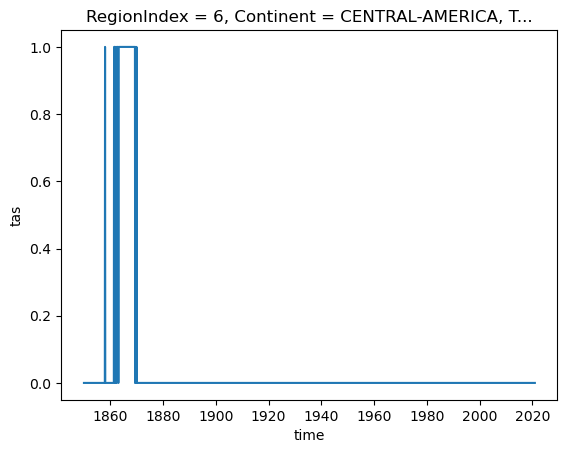

In [21]:
np.isnan(test_hadcrut["tas"].sel(RegionIndex=6)).plot()

In [251]:
test_annual.sel(RegionIndex=22)

<xarray.DataArray 'tas' (realization: 1, year: 171)> Size: 1kB
array([[        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan, -0.27904588,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,  0.28640837,         nan,         nan,
         0.40247936, -0.07118829, -0.28623054, -0.63655709, -0.48894385,
         0.59857554, -0.61162272,  0.20103361,  0.13179346,  0.31840481,
         0.31043029,         nan,  0.85585226,  0.63074603,  0.41085024,
                nan,         nan,  0.07475988,  0.04125018,  0.14057312,
        -0.70297471,  0.41115365, -0.3616489 ,  0.1935959 , -0.82563927,
        -0.39834511,  0.54224887, -0.0392979 , -0.44378685, -0.25301747,
        -0.60798639,  0.03417114, -0.185241  , -0.2941867 ,  0.39539107,
         0.0048075 ,  0.46385837,  0.06286275, -0.41339034, -0.25892738,
        -0.10745476, -0.00498821,  0.24153348,  0.04221306,  0.17526556,
        -0.36575334, -0.00638375,  0.24872907,  0.08916277, -0.15257418,
        -0.19539619, -0.27223301,  0.02910098,  0.22962943,  0.08616761,
         0.15307084, -0.16734795, -0.14272572,  0.10558211, -0.22945793,
        -0.1390682 ,  0.07127474, -0.30317993, -0.15031438,  0.16846114,
         0.1061728 , -0.31643891, -0.03282665,  0.36048726, -0.31113073,
        -0.28583102, -0.26362207,  0.04191682, -0.03090861,  0.34888507,
         0.30502439,  0.05760988,  0.00594337,  0.32267345,  0.19811728,
         0.04659876,  0.0633407 ,  0.4472151 ,  0.39570132,  0.03917197,
         0.29059715,  0.62549488, -0.13435293,  0.25878634, -0.09666554,
         0.13730897,  0.47591838,  0.56000832,  0.724543  ,  0.12124845,
         0.19497783,  0.37068753,  0.38553045,  0.5781208 ,  0.60726741,
         0.91927402,  0.80014716,  0.65256823,  0.50509381,  1.06306757,
         1.09580522,  0.40324137,  0.56595821,  0.69109091,  0.55865915,
         0.7983653 ,  1.17776429,  0.81421262,  0.91345066,         nan,
         0.96683845]])
Coordinates:
    RegionIndex   int64 8B 22
    Continent     <U15 60B 'AFRICA'
    Type          <U10 40B 'Land'
    RegionName    <U25 100B 'Central-Africa'
    RegionAbbrev  <U4 16B 'CAF'
  * realization   (realization) int64 8B 1
  * year          (year) int64 1kB 1850 1851 1852 1853 ... 2017 2018 2019 2020

In [1]:
test_annual.sel(RegionIndex=6).plot()
# test_annual.sel(RegionIndex=22, year=slice("1920", None))#.plot()

NameError: name 'test_annual' is not defined

In [240]:
startyear2

<xarray.DataArray 'year' (realization: 1, RegionIndex: 58)> Size: 464B
array([[1904., 1909., 1920., 1853., 1850., 1850., 1850., 1885., 1850.,
        1901., 1901., 1894., 1901., 1880., 1870., 1850., 1904., 1850.,
        1850., 1850., 1889., 1886., 1902., 1898., 1902., 1899., 1892.,
        1906., 1909., 1850., 1870., 1892., 1875., 1875., 1875., 1872.,
        1878., 1875., 1882., 1901., 1880., 1868., 1879., 1883., 1957.,
          nan, 1933., 1909., 1925., 1977., 1850., 1886., 1880., 1876.,
        1876., 1898., 1855., 1985.]])
Coordinates:
  * RegionIndex   (RegionIndex) int64 464B 0 1 2 3 4 5 6 ... 52 53 54 55 56 57
    Continent     (RegionIndex) <U15 3kB 'POLAR' 'NORTH-AMERICA' ... 'SOUTHERN'
    Type          (RegionIndex) <U10 2kB 'Land' 'Land' ... 'Ocean' 'Ocean'
    RegionName    (RegionIndex) <U25 6kB 'Greenland/Iceland' ... 'Southern-Oc...
    RegionAbbrev  (RegionIndex) <U4 928B 'GIC' 'NWN' 'NEN' ... 'EIO' 'SIO' 'SOO'
  * realization   (realization) int64 8B 1

In [241]:
startyear_full

<xarray.DataArray (realization: 1, RegionIndex: 58)> Size: 464B
array([[1904., 1909., 1920., 1853., 1850., 1850., 1870., 1888., 1883.,
        1901., 1901.,   nan, 1901., 1888., 1946., 1958., 1904., 1850.,
        1850., 1857., 1894.,   nan,   nan, 1901., 1946., 1899., 1895.,
        1946., 1909., 1869., 1877., 1898., 1877., 1882., 1875., 1875.,
        1878., 1875., 1882., 1944., 1880., 1868., 1944., 1946., 1957.,
          nan, 1933., 1949., 1951., 1979., 1946., 1946., 1964., 1876.,
        1944., 1946., 1947., 1999.]])
Coordinates:
  * RegionIndex   (RegionIndex) int64 464B 0 1 2 3 4 5 6 ... 52 53 54 55 56 57
    Continent     (RegionIndex) <U15 3kB 'POLAR' 'NORTH-AMERICA' ... 'SOUTHERN'
    Type          (RegionIndex) <U10 2kB 'Land' 'Land' ... 'Ocean' 'Ocean'
    RegionName    (RegionIndex) <U25 6kB 'Greenland/Iceland' ... 'Southern-Oc...
    RegionAbbrev  (RegionIndex) <U4 928B 'GIC' 'NWN' 'NEN' ... 'EIO' 'SIO' 'SOO'
  * realization   (realization) int64 8B 1

In [ ]:

complete_tseries = ~np.isnan(test_annual).any(dim="year") # Regions without any nans
absent_tseries = (startyear == test_annual.year[-1]) # Regions with all nans

# Set the complete years to the record start year
startyear_full = xr.where(complete_tseries, test_annual.year[0], startyear)
# Set the years with consistent missing data to no start year
startyear_full = xr.where(absent_tseries, np.nan, startyear_full)

# The missing regions are 21, 22, 40, and 41. All characterized by missing data recently.
# This is honestly why we end in 2020 because the recent missing data probably just means
# that it hasn't been assimilated or publicly.

# When the record ends in 2020, Region 11 in S. America goes to a nan also because of recent missing data.

In [218]:
test_annual.sel(RegionIndex=22, year=slice("1902", "1911")).mean()

<xarray.DataArray 'tas' ()> Size: 8B
array(-0.1008849)
Coordinates:
    RegionIndex   int64 8B 22
    Continent     <U15 60B 'AFRICA'
    Type          <U10 40B 'Land'
    RegionName    <U25 100B 'Central-Africa'
    RegionAbbrev  <U4 16B 'CAF'

In [216]:
test_roll.sel(RegionIndex=22, year=slice("1900", "1930"))

<xarray.DataArray 'tas' (realization: 1, year: 31)> Size: 248B
array([[        nan,         nan, -0.1008849 , -0.11155675, -0.08451784,
        -0.04422557, -0.05343048, -0.05145739,  0.0754407 ,  0.21625216,
         0.31622928,  0.280936  ,         nan,         nan,         nan,
                nan,         nan,  0.23277633,  0.08058869,  0.02594492,
        -0.12861627, -0.15858614, -0.08850264, -0.09990842, -0.14841212,
        -0.18777118, -0.17827235, -0.2159706 , -0.19832981, -0.24710807,
        -0.12500503]])
Coordinates:
    RegionIndex   int64 8B 22
    Continent     <U15 60B 'AFRICA'
    Type          <U10 40B 'Land'
    RegionName    <U25 100B 'Central-Africa'
    RegionAbbrev  <U4 16B 'CAF'
  * realization   (realization) int64 8B 1
  * year          (year) int64 248B 1900 1901 1902 1903 ... 1927 1928 1929 1930

In [200]:
# Center = False labels at the end of the window when I want the start.
test_roll = test_annual.rolling(dim={"year": 10}, center=False, min_periods=8).mean(skipna=True) #, min_periods=8)

test_roll.sel(RegionIndex=22).values #, year=1920)

array([[            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             na

In [208]:
test_annual.sel(RegionIndex=22, year=slice("1911", "1920")).mean()

<xarray.DataArray 'tas' ()> Size: 8B
array(0.280936)
Coordinates:
    RegionIndex   int64 8B 22
    Continent     <U15 60B 'AFRICA'
    Type          <U10 40B 'Land'
    RegionName    <U25 100B 'Central-Africa'
    RegionAbbrev  <U4 16B 'CAF'

In [209]:
test_roll.sel(RegionIndex=22, year=slice("1909", "1920"))

<xarray.DataArray 'tas' (realization: 1, year: 12)> Size: 96B
array([[        nan,         nan, -0.1008849 , -0.11155675, -0.08451784,
        -0.04422557, -0.05343048, -0.05145739,  0.0754407 ,  0.21625216,
         0.31622928,  0.280936  ]])
Coordinates:
    RegionIndex   int64 8B 22
    Continent     <U15 60B 'AFRICA'
    Type          <U10 40B 'Land'
    RegionName    <U25 100B 'Central-Africa'
    RegionAbbrev  <U4 16B 'CAF'
  * realization   (realization) int64 8B 1
  * year          (year) int64 96B 1909 1910 1911 1912 ... 1917 1918 1919 1920

In [199]:
test_roll = test_annual.rolling(dim={"year": 10}, center=True, min_periods=8).mean(skipna=True) #, min_periods=8)

test_roll.sel(RegionIndex=22).values #, year=1920)

array([[            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             na

In [195]:
start_yr = 1920
test_annual.sel(year=slice(start_yr, start_yr+9), RegionIndex=22).mean(skipna=True)

<xarray.DataArray 'tas' ()> Size: 8B
array(-0.12861627)
Coordinates:
    RegionIndex   int64 8B 22
    Continent     <U15 60B 'AFRICA'
    Type          <U10 40B 'Land'
    RegionName    <U25 100B 'Central-Africa'
    RegionAbbrev  <U4 16B 'CAF'

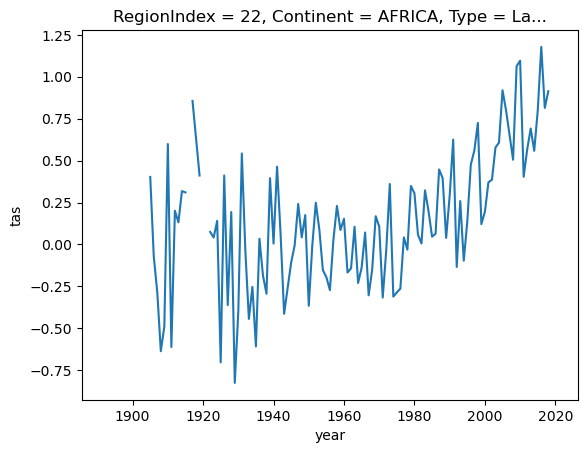

In [139]:
test_annual.sel(RegionIndex=22).plot()

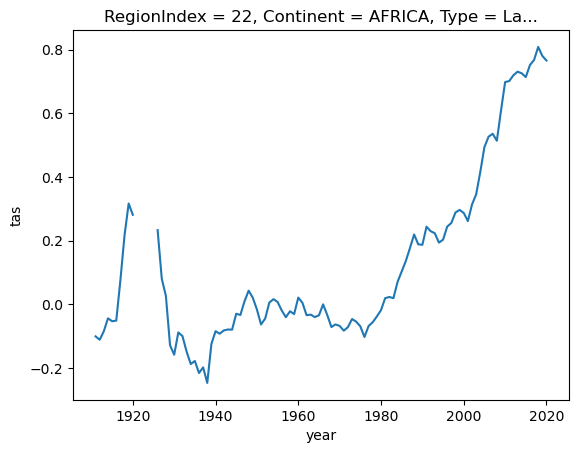

In [140]:
test_roll.sel(RegionIndex=22).plot()

In [115]:
startyear.sel(RegionIndex=45)

<xarray.DataArray 'year' (realization: 1)> Size: 8B
array([2020.])
Coordinates:
    RegionIndex   int64 8B 45
    Continent     <U15 60B 'POLAR'
    Type          <U10 40B 'Land'
    RegionName    <U25 100B 'W.Antarctica'
    RegionAbbrev  <U4 16B 'WAN'
  * realization   (realization) int64 8B 1

In [123]:
startyear_full

<xarray.DataArray (realization: 1, RegionIndex: 58)> Size: 464B
array([[1903., 1908., 1919., 1852., 1850., 1850., 1869., 1887., 1882.,
        1900., 1900.,   nan, 1900., 1887., 1945., 1957., 1903., 1850.,
        1850., 1856., 1893., 2019., 2019., 1900., 1945., 1898., 1894.,
        1945., 1908., 1868., 1876., 1897., 1876., 1881., 1874., 1874.,
        1877., 1874., 1881., 1943., 1879., 1867., 1943., 1945., 1956.,
          nan, 1932., 1948., 1950., 1978., 1945., 1945., 1963., 1875.,
        1943., 1945., 1946., 1998.]])
Coordinates:
  * RegionIndex   (RegionIndex) int64 464B 0 1 2 3 4 5 6 ... 52 53 54 55 56 57
    Continent     (RegionIndex) <U15 3kB 'POLAR' 'NORTH-AMERICA' ... 'SOUTHERN'
    Type          (RegionIndex) <U10 2kB 'Land' 'Land' ... 'Ocean' 'Ocean'
    RegionName    (RegionIndex) <U25 6kB 'Greenland/Iceland' ... 'Southern-Oc...
    RegionAbbrev  (RegionIndex) <U4 928B 'GIC' 'NWN' 'NEN' ... 'EIO' 'SIO' 'SOO'
  * realization   (realization) int64 8B 1

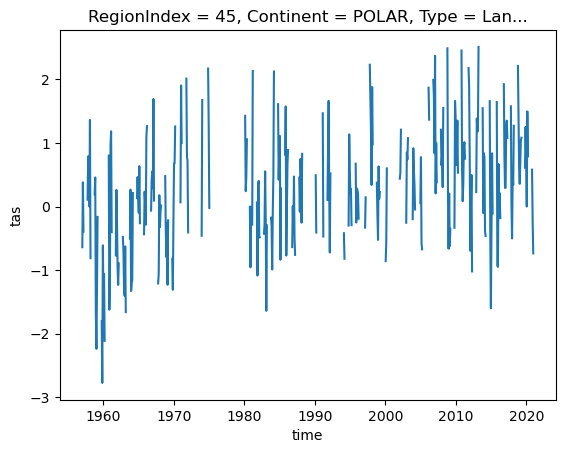

In [116]:
test_hadcrut["tas"].sel(RegionIndex=45).plot()

Ok, this is actually a great example because the missing data is actually very recent.

In [99]:
test_startyear

<xarray.DataArray (realization: 1, RegionIndex: 58)> Size: 464B
array([[1903., 1908., 1919., 1852., 1850., 1850., 1869., 1887., 1882.,
        1900., 1900., 2020., 1900., 1887., 1945., 1957., 1903., 1850.,
        1850., 1856., 1893., 2019.,   nan,   nan, 1945., 1898., 1894.,
        1945., 1908., 1868., 1876., 1897., 1876., 1881., 1874., 1874.,
        1877., 1874., 1881., 1943.,   nan,   nan, 1943., 1945., 1956.,
        2024., 1932., 1948., 1950., 1978., 1945., 1945., 1963., 1875.,
        1943., 1945., 1946., 1998.]])
Coordinates:
  * RegionIndex   (RegionIndex) int64 464B 0 1 2 3 4 5 6 ... 52 53 54 55 56 57
    Continent     (RegionIndex) <U15 3kB 'POLAR' 'NORTH-AMERICA' ... 'SOUTHERN'
    Type          (RegionIndex) <U10 2kB 'Land' 'Land' ... 'Ocean' 'Ocean'
    RegionName    (RegionIndex) <U25 6kB 'Greenland/Iceland' ... 'Southern-Oc...
    RegionAbbrev  (RegionIndex) <U4 928B 'GIC' 'NWN' 'NEN' ... 'EIO' 'SIO' 'SOO'
  * realization   (realization) int64 8B 1
    year          int64 8B 1850

In [98]:
test_startyear.sel(RegionIndex=40)

<xarray.DataArray (realization: 1)> Size: 8B
array([nan])
Coordinates:
    RegionIndex   int64 8B 40
    Continent     <U15 60B 'OCEANIA'
    Type          <U10 40B 'Land'
    RegionName    <U25 100B 'C.Australia'
    RegionAbbrev  <U4 16B 'CAU'
  * realization   (realization) int64 8B 1
    year          int64 8B 1850

In [81]:
test_annual["year"].where(np.isnan(test_annual)).max(dim="year")

<xarray.DataArray 'year' (realization: 1, RegionIndex: 58)> Size: 464B
array([[1903., 1908., 1919., 1852.,   nan,   nan, 1869., 1887., 1882.,
        1900., 1900., 2020., 1900., 1887., 1945., 1957., 1903.,   nan,
          nan, 1856., 1893., 2019., 2023., 2023., 1945., 1898., 1894.,
        1945., 1908., 1868., 1876., 1897., 1876., 1881., 1874., 1874.,
        1877., 1874., 1881., 1943., 2023., 2023., 1943., 1945., 1956.,
        2024., 1932., 1948., 1950., 1978., 1945., 1945., 1963., 1875.,
        1943., 1945., 1946., 1998.]])
Coordinates:
  * RegionIndex   (RegionIndex) int64 464B 0 1 2 3 4 5 6 ... 52 53 54 55 56 57
    Continent     (RegionIndex) <U15 3kB ...
    Type          (RegionIndex) <U10 2kB ...
    RegionName    (RegionIndex) <U25 6kB ...
    RegionAbbrev  (RegionIndex) <U4 928B ...
  * realization   (realization) int64 8B 1

In [61]:
np.isnan(skipna_test.sel(RegionIndex=1)).sum()


<xarray.DataArray 'tas' ()> Size: 8B
array(55)
Coordinates:
    RegionIndex   int64 8B 1
    Continent     <U15 60B ...
    Type          <U10 40B ...
    RegionName    <U25 100B ...
    RegionAbbrev  <U4 16B ...

In [63]:
old_test.sel(RegionIndex=1)

<xarray.DataArray 'tas' (realization: 1, year: 175)> Size: 1kB
array([[            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan, -3.04326501e-01,
         1.35010501e-02,             nan, -2.13628464e-01,
        -1.65440187e+00,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan, -8.99149396e-01,
        -8.19196752e-01, -1.54734556e+00, -5.87108588e-01,
        -7.42266124e-01, -8.16229294e-01, -6.94419295e-01,
        -1.09538071e+00,  4.58579646e-02, -2.08291514e-01,
        -1.60672501e+00, -1.00368849e+00, -1.54933603e+00,
...
         8.09555363e-02, -1.08972324e-01, -1.65523523e-03,
        -2.76517601e-01, -8.86691642e-01, -1.30043334e+00,
        -1.36632973e-01, -6.22442488e-01, -7.70672578e-01,
         2.40639136e-01,  6.38627444e-01,  4.90985404e-01,
         2.46207892e-01,  3.55131838e-01,  1.85383288e+00,
        -8.32916557e-01,  2.56777605e-01,  1.55349845e-01,
        -2.42234084e-01,  3.73993259e-01,  1.22922920e+00,
         6.62831708e-01,  3.77127169e-01, -9.75507331e-03,
         5.84229563e-01,  4.46481656e-01,  1.42295056e+00,
         5.12041834e-01,  7.84568639e-01, -2.25704556e-01,
         1.17843260e+00,  1.91872144e+00,  5.86846011e-01,
         7.11393993e-01,  1.14737299e+00,  1.06113710e+00,
         1.17518793e+00,  6.92221084e-01,  1.54172478e+00,
         1.24717442e+00,  7.97866985e-01,  1.28709809e-01,
         3.03388454e-01,  1.48819144e+00,  8.30793675e-01,
         5.59669309e-01,  9.04998840e-01,  1.26476614e+00,
         2.10896052e+00,  2.57861839e+00,  1.57366341e+00,
         1.38661411e+00,  1.69550453e+00,  1.02862141e+00,
         1.00775400e+00,  1.13707945e+00,  2.23856660e+00,
         1.77540215e+00]])
Coordinates:
    RegionIndex   int64 8B 1
    Continent     <U15 60B ...
    Type          <U10 40B ...
    RegionName    <U25 100B ...
    RegionAbbrev  <U4 16B ...
  * realization   (realization) int64 8B 1
  * year          (year) int64 1kB 1850 1851 1852 1853 ... 2021 2022 2023 2024

In [ ]:
skipna_test.sel(RegionIndex=1)

<xarray.DataArray 'tas' (realization: 1, year: 175)> Size: 1kB
array([[            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan, -5.87108588e-01,
        -7.42266124e-01, -8.16229294e-01, -6.94419295e-01,
                    nan,             nan,             nan,
                    nan,             nan, -1.54933603e+00,
...
         8.09555363e-02, -1.08972324e-01, -1.65523523e-03,
        -2.76517601e-01, -8.86691642e-01, -1.30043334e+00,
        -1.36632973e-01, -6.22442488e-01, -7.70672578e-01,
         2.40639136e-01,  6.38627444e-01,  4.90985404e-01,
         2.46207892e-01,  3.55131838e-01,  1.85383288e+00,
        -8.32916557e-01,  2.56777605e-01,  1.55349845e-01,
        -2.42234084e-01,  3.73993259e-01,  1.22922920e+00,
         6.62831708e-01,  3.77127169e-01, -9.75507331e-03,
         5.84229563e-01,  4.46481656e-01,  1.42295056e+00,
         5.12041834e-01,  7.84568639e-01, -2.25704556e-01,
         1.17843260e+00,  1.91872144e+00,  5.86846011e-01,
         7.11393993e-01,  1.14737299e+00,  1.06113710e+00,
         1.17518793e+00,  6.92221084e-01,  1.54172478e+00,
         1.24717442e+00,  7.97866985e-01,  1.28709809e-01,
         3.03388454e-01,  1.48819144e+00,  8.30793675e-01,
         5.59669309e-01,  9.04998840e-01,  1.26476614e+00,
         2.10896052e+00,  2.57861839e+00,  1.57366341e+00,
         1.38661411e+00,  1.69550453e+00,  1.02862141e+00,
         1.00775400e+00,  1.13707945e+00,  2.23856660e+00,
         1.77540215e+00]])
Coordinates:
    RegionIndex   int64 8B 1
    Continent     <U15 60B ...
    Type          <U10 40B ...
    RegionName    <U25 100B ...
    RegionAbbrev  <U4 16B ...
  * realization   (realization) int64 8B 1
  * year          (year) int64 1kB 1850 1851 1852 1853 ... 2021 2022 2023 2024

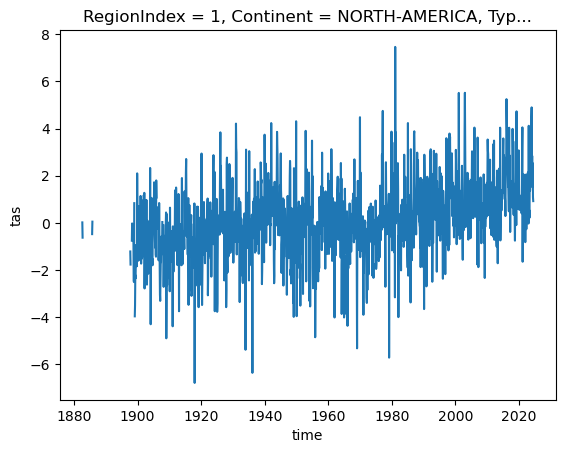

In [48]:
test_hadcrut["tas"].sel(RegionIndex=1).plot()

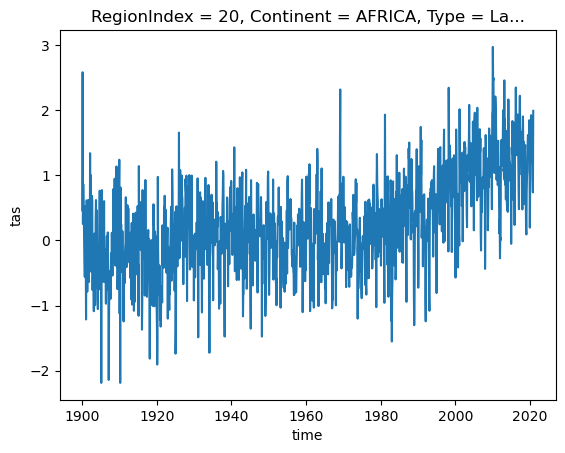

In [ ]:
test_gistemp["tas"].sel(RegionIndex=20).plot()

In [20]:
old_test.sel(RegionIndex=1)

<xarray.DataArray 'tas' (realization: 1, year: 141)> Size: 1kB
array([[        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
        -0.40432731, -0.07164916, -0.47533614, -0.38401471, -0.54747763,
         0.63580451, -0.05859088, -0.87681925, -0.45630674, -1.48356952,
        -0.48862604, -0.59126548,  0.53834088, -0.48373186,  0.3003387 ,
         1.13818151, -0.90125986, -1.40659576, -0.735143  , -0.55867621,
        -0.55658281, -0.05068282, -0.47557558,  0.60056476, -0.16982701,
         0.01408023,  1.77592468, -0.77130627,  0.76009889,  0.23653887,
         0.26875634,  0.92569112, -0.53840299, -1.27747542,  0.6408584 ,
        -0.2750941 , -0.19772301,  0.34456676,  1.04449806,  0.22388986,
         1.49125522,  1.18146446,  0.87644366,  0.8201125 ,  1.48309646,
        -0.06222912, -0.45248927,  0.81940913, -1.05032495, -0.44323442,
        -0.60832694, -0.82071719,  0.62705756,  0.6026892 ,  0.30500023,
        -1.3051257 , -0.87513956,  0.82604126,  0.58323902,  0.08513153,
         0.77788848, -0.43861869,  0.44797056,  0.80197022, -0.82583088,
        -0.62783113, -0.29756672,  0.54604722, -0.25198014,  0.6794708 ,
        -0.2090837 , -0.57768493, -0.78607903, -0.09142724, -0.25754944,
        -0.54175825,  0.95251579,  0.74151287,  0.53666222,  0.20357888,
         1.54060199,  1.0506317 , -0.10277927,  0.74812978,  0.67736456,
        -0.02233958,  0.98728001,  1.48498386,  0.98131078,  0.7376388 ,
         0.36463318,  1.22309726,  0.55442013,  1.6660821 ,  0.9901943 ,
         0.49360006, -0.10388399,  1.5005103 ,  2.06543878,  0.7243069 ,
         1.58191389,  1.07585757,  1.43063458,  1.13278165,  1.52470424,
         1.97609758,  1.45198598,  0.80241047,  0.41068933,  0.91508046,
         1.65944739,  0.69775181,  1.01890351,  1.39957793,  1.53019681,
         2.58993182,  2.67463972,  1.79727036,  1.6518903 ,  1.88773738,
         1.24635093]])
Coordinates:
    RegionIndex   int64 8B 1
    Continent     <U15 60B ...
    Type          <U10 40B ...
    RegionName    <U25 100B ...
    RegionAbbrev  <U4 16B ...
  * realization   (realization) int64 8B 1
  * year          (year) int64 1kB 1880 1881 1882 1883 ... 2017 2018 2019 2020

In [21]:
skipna_test.sel(RegionIndex=1)

<xarray.DataArray 'tas' (realization: 1, year: 141)> Size: 1kB
array([[        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
        -0.40432731, -0.07164916, -0.47533614, -0.38401471, -0.54747763,
         0.63580451, -0.05859088, -0.87681925, -0.45630674, -1.48356952,
        -0.48862604, -0.59126548,  0.53834088, -0.48373186,  0.3003387 ,
         1.13818151, -0.90125986, -1.40659576, -0.735143  , -0.55867621,
        -0.55658281, -0.05068282, -0.47557558,  0.60056476, -0.16982701,
         0.01408023,  1.77592468, -0.77130627,  0.76009889,  0.23653887,
         0.26875634,  0.92569112, -0.53840299, -1.27747542,  0.6408584 ,
        -0.2750941 , -0.19772301,  0.34456676,  1.04449806,  0.22388986,
         1.49125522,  1.18146446,  0.87644366,  0.8201125 ,  1.48309646,
        -0.06222912, -0.45248927,  0.81940913, -1.05032495, -0.44323442,
        -0.60832694, -0.82071719,  0.62705756,  0.6026892 ,  0.30500023,
        -1.3051257 , -0.87513956,  0.82604126,  0.58323902,  0.08513153,
         0.77788848, -0.43861869,  0.44797056,  0.80197022, -0.82583088,
        -0.62783113, -0.29756672,  0.54604722, -0.25198014,  0.6794708 ,
        -0.2090837 , -0.57768493, -0.78607903, -0.09142724, -0.25754944,
        -0.54175825,  0.95251579,  0.74151287,  0.53666222,  0.20357888,
         1.54060199,  1.0506317 , -0.10277927,  0.74812978,  0.67736456,
        -0.02233958,  0.98728001,  1.48498386,  0.98131078,  0.7376388 ,
         0.36463318,  1.22309726,  0.55442013,  1.6660821 ,  0.9901943 ,
         0.49360006, -0.10388399,  1.5005103 ,  2.06543878,  0.7243069 ,
         1.58191389,  1.07585757,  1.43063458,  1.13278165,  1.52470424,
         1.97609758,  1.45198598,  0.80241047,  0.41068933,  0.91508046,
         1.65944739,  0.69775181,  1.01890351,  1.39957793,  1.53019681,
         2.58993182,  2.67463972,  1.79727036,  1.6518903 ,  1.88773738,
         1.24635093]])
Coordinates:
    RegionIndex   int64 8B 1
    Continent     <U15 60B ...
    Type          <U10 40B ...
    RegionName    <U25 100B ...
    RegionAbbrev  <U4 16B ...
  * realization   (realization) int64 8B 1
  * year          (year) int64 1kB 1880 1881 1882 1883 ... 2017 2018 2019 2020

### Process time series into unforced trends as a function of trend duration

Using code from:  

trend_uncertainty/PIC_trend_preproc.ipynb

__Define functions:__

In [6]:
def get_trends_allstartyears(data,duration,startyears,dim='year'):
    '''
    Calculate: 
    a. trends of a given duration
    '''
    
    description = 'Trends for an unforced Pre-Industrial Control simulation sampled by timeseries startyear and duration.'
    
    # Initialize list to save to
    trends_list = []
    
    for i,startyear in enumerate(startyears):
        
        _startyr = startyear
        _endyr   = startyear + duration - 1

        _tsel = data.sel(year=slice(_startyr,_endyr)) # index differently here because the dates are different

        # Calculate the slope
        # print(_tsel)
        # print(dim)
        _tsel_polyfit = _tsel.polyfit(dim=dim, deg=1, skipna=False)['polyfit_coefficients'].sel(degree=1)
        _tsel_slopes  = _tsel_polyfit.drop('degree')
        
        trends_list.append(_tsel_slopes.assign_coords({'startyear':startyear}).expand_dims('startyear'))
        
    out = xr.concat(trends_list,dim='startyear').assign_coords({'duration':duration}).expand_dims('duration')
        
    return out

In [7]:
def compute_trends_wrapper(data,durations=np.arange(5,81,),**kwargs):
    '''
    Wrapper for running 'get_allvar_allstartyears' for different durations.
    Setup with correct startyears and concatenate at the end.
    '''
    
    first_year = data['year'][0]
    last_year  = data['year'][-1]

    trends_allstartyear_allduration_list = []

    for duration in durations:
        print(duration,end=' ')
        _startyears = np.arange(first_year,last_year+2-duration,1)

        allvar_onedur_ds = get_trends_allstartyears(data,
                                                    duration=duration,
                                                    startyears=_startyears,
                                                    **kwargs
                                                   )
        
        trends_allstartyear_allduration_list.append(allvar_onedur_ds)
                
    trends_allstartyear_allduration_ds = xr.concat(trends_allstartyear_allduration_list,dim='duration')
        
    # Add metadata
    trends_allstartyear_allduration_ds = trends_allstartyear_allduration_ds.assign_coords({"RegionName":   ("RegionIndex", data.RegionName)})
    trends_allstartyear_allduration_ds = trends_allstartyear_allduration_ds.assign_coords({"RegionAbbrev": ("RegionIndex", data.RegionAbbrev)})

    trends_allstartyear_allduration_ds.name = 'TAS_trends'
    
    return trends_allstartyear_allduration_ds

### Compute trends for all durations and save

In [8]:
gistemp_tas_var = 'tas'
hadcrut5_tas_var = 'tas'

#### GISTEMP 5x5

In [9]:
test_ds1 = xr.open_dataset(gistemp_5x5_files[0])
test_ds2 = xr.open_dataset(gistemp_5x5_files[1])

In [10]:
test_ds1 = xr.open_dataset(hadcrut5_files[0])
test_ds2 = xr.open_dataset(hadcrut5_files[1])

In [11]:
test_ds2

<xarray.Dataset>
Dimensions:       (RegionIndex: 58, realization: 1, time: 1476)
Coordinates:
  * realization   (realization) int64 1
  * time          (time) datetime64[ns] 1900-01-16T12:00:00 ... 2022-12-16T12...
  * RegionIndex   (RegionIndex) int64 0 1 2 3 4 5 6 7 ... 51 52 53 54 55 56 57
    RegionAbbrev  (RegionIndex) object ...
    RegionName    (RegionIndex) object ...
Data variables:
    tas           (realization, time, RegionIndex) float64 ...

In [12]:
test_ds1

<xarray.Dataset>
Dimensions:      (duration: 119, latitude: 36, longitude: 72, realization: 1)
Coordinates:
    startyear    int64 ...
  * longitude    (longitude) float64 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
  * latitude     (latitude) float64 -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
  * duration     (duration) int64 3 4 5 6 7 8 9 ... 115 116 117 118 119 120 121
  * realization  (realization) int64 1
Data variables:
    tas          (duration, latitude, longitude, realization) float64 ...

In [13]:
gistemp_5x5_ds = xr.open_mfdataset(gistemp_5x5_files,chunks={'RegionIndex':1})

In [14]:
%%time
gistemp_filelist = []
for _file in gistemp_5x5_files:
    _gistemp_ds = xr.open_dataset(_file)
    _gistemp_annual = _gistemp_ds[gistemp_tas_var].groupby('time.year').mean('time')

    gistemp_filelist.append(_gistemp_annual)

gistemp_annual = xr.concat(gistemp_filelist, dim="realization")

CPU times: user 12.9 s, sys: 239 ms, total: 13.1 s
Wall time: 13.9 s


In [15]:
%%time

gistemp_trends_all = compute_trends_wrapper(gistemp_annual,durations=np.arange(3,122,1))

3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 CPU times: user 1min 4s, sys: 3.33 s, total: 1min 7s
Wall time: 1min 13s


In [17]:
gistemp_trends_all.to_netcdf('%s/%s/ensembleChunks_0001_0200.trends.190001-202012.nc' % (obslens_tseries_dir,'GISTEMP_5x5/20240820/'))

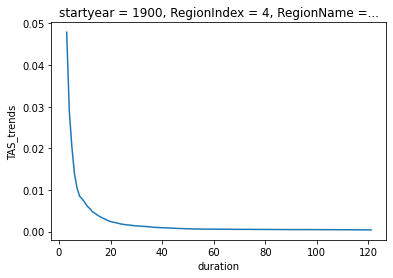

In [18]:
gistemp_trends_all.sel(RegionIndex=4, startyear=1900).sortby("realization").std("realization").plot()

In [19]:
del gistemp_5x5_ds,gistemp_annual,gistemp_trends_all

#### HadCRUT5

In [24]:
%%time
hadcrut5_filelist = []
for _file in hadcrut5_files:
    # print(_file)
    _hadcrut5_ds = xr.open_dataset(_file)
    _hadcrut5_annual = _hadcrut5_ds[hadcrut5_tas_var].groupby('time.year').mean('time')

    hadcrut5_filelist.append(_hadcrut5_annual)

hadcrut5_annual = xr.concat(hadcrut5_filelist, dim="realization")

/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/

CPU times: user 13.6 s, sys: 181 ms, total: 13.8 s
Wall time: 20.7 s


In [28]:
%%time

hadcrut5_trends_all = compute_trends_wrapper(hadcrut5_annual,durations=np.arange(3,122,1))

3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 CPU times: user 1min 7s, sys: 1.09 s, total: 1min 8s
Wall time: 1min 13s


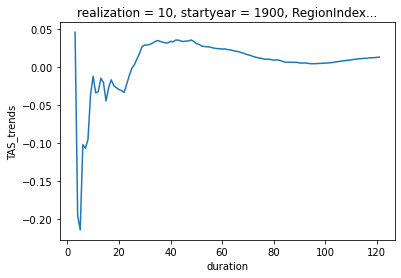

In [29]:
hadcrut5_trends_all.sel(startyear=1900,RegionIndex=0, realization=10).plot()

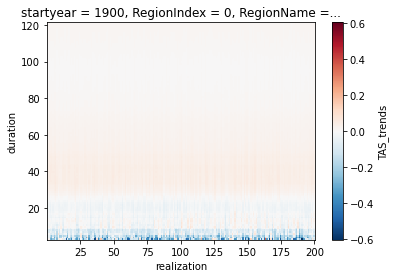

In [30]:
hadcrut5_trends_all.sel(startyear=1900,RegionIndex=0,).sortby("realization").plot()

#### Interesting behavior in the observational uncertainty curve in Central North America when starting the record at 1900.

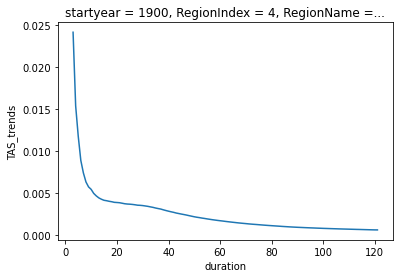

In [31]:
hadcrut5_trends_all.sel(RegionIndex=4, startyear=1900).sortby("realization").std("realization").plot()

In [32]:
hadcrut5_trends_all.to_netcdf('%s/%s/HadCRUT.5.0.2.0_1_200.trends.190001-202212.nc' % (obslens_tseries_dir,'HadCRUT5/20240820/'))

In [33]:
del hadcrut5_annual,hadcrut5_trends_all